In [1]:
from google.colab import drive
# ignore drive.mount() if you are not using colab 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')



# LOAD DATA

In [5]:
file1 = open('/content/gdrive/My Drive/Machine_learning/IDS_1/Train_data.csv', 'rb')
file2 = open('/content/gdrive/My Drive/Machine_learning/IDS_1/Test_data.csv', 'rb')

train = pd.read_csv(file1)
test = pd.read_csv(file2)

In [6]:
print(train.head(4))

print("Training data has {} rows & {} columns".format(train.shape[0],train.shape[1]))

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal

[4 rows x 42 columns]
Training data has 25192 rows & 42 columns


In [7]:
print(test.head(4))

print("Testing data has {} rows & {} columns".format(test.shape[0],test.shape[1]))

   duration protocol_type  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0         0           tcp  ...                  1.0                      1.0
1         0           tcp  ...                  1.0                      1.0
2         2           tcp  ...                  0.0                      0.0
3         0          icmp  ...                  0.0                      0.0

[4 rows x 41 columns]
Testing data has 22544 rows & 41 columns


# EXPLORATORY ANALYSIS

In [ ]:
# Descriptive statistics
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [ ]:
#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:
# Attack Class Distribution
train['class'].value_counts()

normal     13449
anomaly    11743
Name: class, dtype: int64

# SCALING NUMERICAL ATTRIBUTES

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

# ENCODING CATEGORICAL ATTRIBUTES

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()


In [ ]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [ ]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

# FEATURE SELECTION

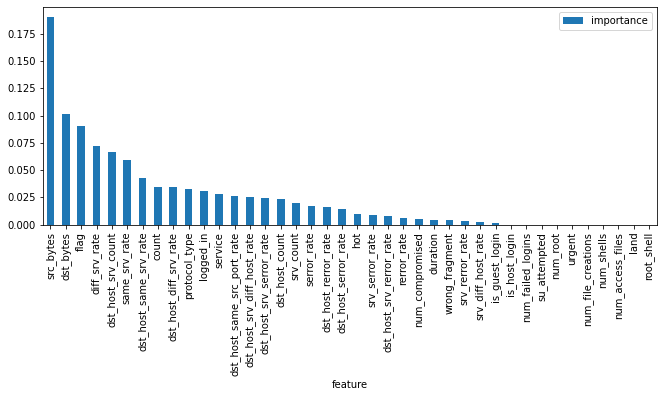

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [ ]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

# DATASET PARTITION

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)

# FITTING MODELS

In [ ]:
from sklearn.svm import SVC 
from sklearn.naive_bayes import BernoulliNB 
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train); 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

# Train Gaussian Naive Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, Y_train)
            
# Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion='entropy', random_state=0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

# EVALUATE MODELS

In [ ]:
from sklearn import metrics

models = []
models.append(('Naive Baye Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))

for i, v in models:
    scores = cross_val_score(v, X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train, v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train, v.predict(X_train))
    classification = metrics.classification_report(Y_train, v.predict(X_train))
    print()
    print('============================== {} Model Evaluation =============================='.format(i))
    print()
    print ("Cross Validation Mean Score:" "\n", scores.mean())
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


============================== Naive Baye Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9071666840303904

Model Accuracy:
 0.9071679709651809

Confusion matrix:
 [[7000 1245]
 [ 392 8997]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.95      0.85      0.90      8245
      normal       0.88      0.96      0.92      9389

    accuracy                           0.91     17634
   macro avg       0.91      0.90      0.91     17634
weighted avg       0.91      0.91      0.91     17634



============================== Decision Tree Classifier Model Evaluation ==============================

Cross Validation Mean Score:
 0.9960869883971739

Model Accuracy:
 1.0

Confusion matrix:
 [[8245    0]
 [   0 9389]]

Classification report:
               precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.00      9389

# VALIDATING MODELS

In [ ]:
for i, v in models:
    accuracy = metrics.accuracy_score(Y_test, v.predict(X_test))
    confusion_matrix = metrics.confusion_matrix(Y_test, v.predict(X_test))
    classification = metrics.classification_report(Y_test, v.predict(X_test))
    print()
    print('============================== {} Model Test Results =============================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        



============================== Naive Baye Classifier Model Test Results ==============================

Model Accuracy:
 0.906721354855782

Confusion matrix:
 [[2981  517]
 [ 188 3872]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.94      0.85      0.89      3498
      normal       0.88      0.95      0.92      4060

    accuracy                           0.91      7558
   macro avg       0.91      0.90      0.91      7558
weighted avg       0.91      0.91      0.91      7558



============================== Decision Tree Classifier Model Test Results ==============================

Model Accuracy:
 0.9947075946017465

Confusion matrix:
 [[3483   15]
 [  25 4035]]

Classification report:
               precision    recall  f1-score   support

     anomaly       0.99      1.00      0.99      3498
      normal       1.00      0.99      1.00      4060

    accuracy                           0.99      7558
   macro avg       0.99   

In [ ]:
#using Artificial neural network
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


file1 = open('/content/gdrive/My Drive/Machine_learning/IDS_1/Train_data.csv', 'rb')
file2 = open('/content/gdrive/My Drive/Machine_learning/IDS_1/Test_data.csv', 'rb')

train1 = pd.read_csv(file1)
test1 = pd.read_csv(file2)



In [ ]:
train1.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
print(train1.head(4))

print("Training data has {} rows & {} columns".format(train1.shape[0],train1.shape[1]))

print(test1.head(4))

print("Testing data has {} rows & {} columns".format(test1.shape[0],test1.shape[1]))

   duration protocol_type  ... dst_host_srv_rerror_rate    class
0         0           tcp  ...                     0.00   normal
1         0           udp  ...                     0.00   normal
2         0           tcp  ...                     0.00  anomaly
3         0           tcp  ...                     0.01   normal

[4 rows x 42 columns]
Training data has 25192 rows & 42 columns
   duration protocol_type  ... dst_host_rerror_rate dst_host_srv_rerror_rate
0         0           tcp  ...                  1.0                      1.0
1         0           tcp  ...                  1.0                      1.0
2         2           tcp  ...                  0.0                      0.0
3         0          icmp  ...                  0.0                      0.0

[4 rows x 41 columns]
Testing data has 22544 rows & 41 columns


In [ ]:
#Exploratory Analysis
# Descriptive statistics
train1.describe()

print(train1['num_outbound_cmds'].value_counts())
print(test1['num_outbound_cmds'].value_counts())

#'num_outbound_cmds' is a redundant column so remove it from both train & test datasets
train1.drop(['num_outbound_cmds'], axis=1, inplace=True)
test1.drop(['num_outbound_cmds'], axis=1, inplace=True)

# Attack Class Distribution
train1['class'].value_counts()


0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


normal     13449
anomaly    11743
Name: class, dtype: int64

In [ ]:
#Scalling numerical attributes
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train1.select_dtypes(include=['float64','int64']).columns
sc_train1 = scaler.fit_transform(train1.select_dtypes(include=['float64','int64']))
sc_test1 = scaler.fit_transform(test1.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf1 = pd.DataFrame(sc_train1, columns = cols)
sc_testdf1 = pd.DataFrame(sc_test1, columns = cols)

In [ ]:
#Encoding categorical attributes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# extract categorical attributes from both training and test sets 
cattrain1 = train1.select_dtypes(include=['object']).copy()
cattest1 = test1.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat1 = cattrain1.apply(encoder.fit_transform)
testcat1 = cattest1.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain1 = traincat1.drop(['class'], axis=1)
cat_Ytrain1 = traincat1[['class']].copy()

In [ ]:
#Union of processed numerical and categorical data
train_x1 = pd.concat([sc_traindf1,enctrain1],axis=1)
train_y1 = cat_Ytrain1
train_x1.shape

test_df1 = pd.concat([sc_testdf1,testcat1],axis=1)
test_df1.shape

(22544, 40)

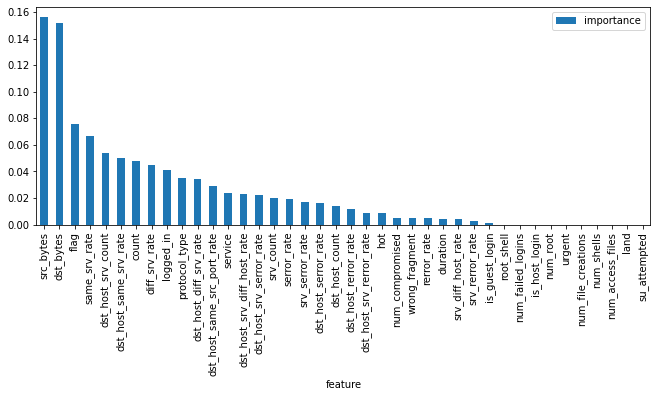

In [ ]:
#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x1, train_y1);

# extract important features
score1 = np.round(rfc.feature_importances_,3)
importances1 = pd.DataFrame({'feature':train_x1.columns,'importance':score1})
importances1 = importances1.sort_values('importance',ascending=False).set_index('feature')

# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances1.plot.bar();

In [ ]:
#Recursive feature elimination
from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x1, train_y1)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), train_x1.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [ ]:
a = [i[0] for i in feature_map]

train_x1 = train_x1.iloc[:,a]
test_df1 = test_df1.iloc[:,a]

In [ ]:
#Dataset Partition
from sklearn.model_selection import train_test_split

X_train1,X_test1,Y_train1,Y_test1 = train_test_split(train_x1,train_y1,train_size=0.70, random_state=2)

#Fitting Models
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense

# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train1, Y_train1, batch_size = 10, epochs = 100)

Epoch 1/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.2211 - accuracy: 0.9226
Epoch 2/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1491 - accuracy: 0.9497
Epoch 3/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1418 - accuracy: 0.9530
Epoch 4/100
1764/1764 [==============================] - 2s 996us/step - loss: 0.1385 - accuracy: 0.9542
Epoch 5/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1336 - accuracy: 0.9567
Epoch 6/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1309 - accuracy: 0.9572
Epoch 7/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1263 - accuracy: 0.9595
Epoch 8/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1224 - accuracy: 0.9605
Epoch 9/100
1764/1764 [==============================] - 2s 1ms/step - loss: 0.1184 - accuracy: 0.9622
Epoch 10/100
1764/1764 [==============================] - 2s 1ms/step -

In [ ]:
yhat_train = (classifier.predict(X_train1) > 0.5)
yhat_test = (classifier.predict(X_test1) > 0.5)

In [ ]:
# PREDICTING FOR TEST DATA
pred_ann = classifier.predict(test_df1)

In [ ]:
#Evaluate Models
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier

classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)

scores = cross_val_score(estimator = classifier,X = X_train1, y = Y_train1, cv = 10, n_jobs = 1)
#should be n_jobs = -1, but seems like doesn`t give more than one CPU

Epoch 1/100
1587/1587 [==============================] - 2s 958us/step - loss: 0.2409 - accuracy: 0.9009
Epoch 2/100
1587/1587 [==============================] - 2s 982us/step - loss: 0.1504 - accuracy: 0.9437
Epoch 3/100
1587/1587 [==============================] - 2s 993us/step - loss: 0.1333 - accuracy: 0.9541
Epoch 4/100
1587/1587 [==============================] - 2s 997us/step - loss: 0.1233 - accuracy: 0.9574
Epoch 5/100
1587/1587 [==============================] - 2s 981us/step - loss: 0.1171 - accuracy: 0.9594
Epoch 6/100
1587/1587 [==============================] - 2s 1ms/step - loss: 0.1135 - accuracy: 0.9615
Epoch 7/100
1587/1587 [==============================] - 2s 985us/step - loss: 0.1111 - accuracy: 0.9619
Epoch 8/100
1587/1587 [==============================] - 2s 996us/step - loss: 0.1093 - accuracy: 0.9624
Epoch 9/100
1587/1587 [==============================] - 2s 988us/step - loss: 0.1073 - accuracy: 0.9638
Epoch 10/100
1587/1587 [==============================] -

In [ ]:
accuracy = metrics.accuracy_score(Y_train1, yhat_train)
confusion_matrix = metrics.confusion_matrix(Y_train1, yhat_train)
classification = metrics.classification_report(Y_train1, yhat_train)
print()
print('============================== ANN Model Evaluation ==============================' )
print()
print ("Cross Validation Mean Score:" "\n", scores.mean())
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()


============================== ANN Model Evaluation ==============================

Cross Validation Mean Score:
 0.9805496335029602

Model Accuracy:
 0.9808891913349211

Confusion matrix:
 [[8012  233]
 [ 104 9285]]

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      8245
           1       0.98      0.99      0.98      9389

    accuracy                           0.98     17634
   macro avg       0.98      0.98      0.98     17634
weighted avg       0.98      0.98      0.98     17634




In [ ]:
#Validate Models
accuracy = metrics.accuracy_score(Y_test1, yhat_test)
confusion_matrix = metrics.confusion_matrix(Y_test1, yhat_test)
classification = metrics.classification_report(Y_test1, yhat_test)
print()
print('============================== ANN Model Test Results ==============================')
print()
print ("Model Accuracy:" "\n", accuracy)
print()
print("Confusion matrix:" "\n", confusion_matrix)
print()
print("Classification report:" "\n", classification) 
print()        


============================== ANN Model Test Results ==============================

Model Accuracy:
 0.9786980682720297

Confusion matrix:
 [[3387  111]
 [  50 4010]]

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3498
           1       0.97      0.99      0.98      4060

    accuracy                           0.98      7558
   macro avg       0.98      0.98      0.98      7558
weighted avg       0.98      0.98      0.98      7558


